In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA

In [54]:
# Célula 2 - Carregar dados
train_df = pd.read_csv("../data/processed/train_processed.csv")
test_df = pd.read_csv("../data/processed/test_processed.csv")

X_train = train_df.drop(columns=["subject", "activity_id", "activity"])
y_train = train_df["activity"]

X_test = test_df.drop(columns=["subject", "activity_id", "activity"])
y_test = test_df["activity"]

print("Shape treino:", X_train.shape)
print("Shape teste:", X_test.shape)

Shape treino: (7352, 66)
Shape teste: (2947, 66)


In [55]:
# Célula 3 - Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [ ]:
# Célula 4 
model = LogisticRegression(max_iter=2000, solver="saga", random_state=42)
# usar step em fração (10% por iteração) para ser robusto
rfe = RFE(estimator=model, n_features_to_select=5, step=0.1)
rfe.fit(X_train_scaled, y_train)
print("Número de features selecionadas:", rfe.n_features_)
print("Features selecionadas:", list(X_train.columns[rfe.support_]))

In [51]:
# Célula 5 - Impacto do número de atributos
scores = []
n_features_range = [10, 20, 30, 50, 100, 150, 200, 300, 400, 561]

cv = StratifiedKFold(5, shuffle=True, random_state=42)

for n in n_features_range:
    rfe = RFE(estimator=model, n_features_to_select=n, step=10)  # step>1 acelera
    X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
    score = cross_val_score(model, X_train_rfe, y_train, cv=cv, n_jobs=-1).mean()
    scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(n_features_range, scores, marker="o")
plt.xlabel("Número de atributos selecionados")
plt.ylabel("Acurácia média (5-fold CV)")
plt.title("Impacto do número de atributos no RFE")
plt.grid(True)
plt.show()

Número de features selecionadas: 5
Features selecionadas: ['tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tBodyGyroJerk-std()-X', 'fBodyAcc-std()-X', 'fBodyAccMag-mean()']


In [30]:
# Célula 6 - RFECV (mais automatizado)
rfecv = RFECV(estimator=model, step=10, cv=cv, scoring="accuracy", n_jobs=-1, verbose=1)
rfecv.fit(X_train_scaled, y_train)

print("Número ótimo de features:", rfecv.n_features_)

selected_features = list(X_train.columns[rfecv.support_])
print("Features escolhidas:", selected_features)


Fitting estimator with 66 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Número ótimo de features: 36
Features escolhidas: ['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z', 'tGravityAcc-std()-X', 'tGravityAcc-std()-Z', 'tBodyAccJerk-std()-Z', 'tBodyGyro-std()-X', 'tBodyGyro-std()-Y', 'tBodyGyroJerk-std()-X', 'tBodyGyroJerk-std()-Y', 'tBodyAccMag-std()', 'tGravityAccMag-std()', 'tBodyAccJerkMag-mean()', 'tBodyGyroMag-mean()', 'fBodyAcc-mean()-Y', 'fBodyAcc-mean()-Z', 'fBodyAcc-std()-X', 'fBodyAcc-std()-Y', 'fBodyAccJerk-mean()-Z', 'fBodyAccJerk-std()-X', 'fBodyAccJerk-std()-Y', 'fBodyAccJerk-std()-Z', 'fBodyGyro-mean()-X', 'fBodyGyro-mean()-Z', 'fBodyGyro-std()-X', 'fBodyGyro-std()-Y', 'fBodyGyro-std()-Z', 'fBodyAccMag-mean()', 'fBodyAccMag-std()', 'fBodyBodyAccJerkMag-std()', 'fBodyBodyGyroMag-std()', 'fBodyBodyGyroJerkMag-mean()', 'fBodyBodyGyroJerkMag-std()']


In [31]:
# Célula 7 - Seleção alternativa (mais rápida) usando L1
l1_model = LogisticRegression(penalty="l1", solver="saga", max_iter=1000, C=0.1)
sfm = SelectFromModel(l1_model)
sfm.fit(X_train_scaled, y_train)

mask = sfm.get_support()
selected_features_l1 = list(X_train.columns[mask])

print("Nº de features selecionadas (L1):", len(selected_features_l1))
print("Features:", selected_features_l1[:20], "...")  # mostra só as 20 primeiras

X_train_l1 = sfm.transform(X_train_scaled)
acc_l1 = cross_val_score(model, X_train_l1, y_train, cv=cv, n_jobs=-1).mean()
print("Acurácia média com features L1:", acc_l1)


Nº de features selecionadas (L1): 41
Features: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z', 'tGravityAcc-std()-X', 'tGravityAcc-std()-Y', 'tGravityAcc-std()-Z', 'tBodyAccJerk-mean()-X', 'tBodyAccJerk-mean()-Z', 'tBodyAccJerk-std()-Y', 'tBodyAccJerk-std()-Z', 'tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-std()-X', 'tBodyGyro-std()-Z', 'tBodyGyroJerk-mean()-X', 'tBodyGyroJerk-mean()-Z'] ...
Acurácia média com features L1: 0.952121514819388


In [32]:
# Célula 8 - Lasso (L1) + Comparação com RFE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

# Modelo Lasso
lasso_model = LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=1000, n_jobs=-1)
lasso_model.fit(X_train_scaled, y_train)

# Analisar coeficientes
coefs = lasso_model.coef_
n_zero_coefs = np.sum(np.all(coefs == 0, axis=0))

print(f"Total de atributos: {X_train.shape[1]}")
print(f"Atributos zerados pelo Lasso: {n_zero_coefs}")

# Seleção de atributos
selected_mask_lasso = np.any(coefs != 0, axis=0)
selected_features_lasso = list(X_train.columns[selected_mask_lasso])

print(f"Número de atributos selecionados pelo Lasso: {len(selected_features_lasso)}")

# Comparação RFE vs Lasso
set_rfe = set(selected_features)  
set_lasso = set(selected_features_lasso)

common_features = list(set_rfe.intersection(set_lasso))
unique_to_rfe = list(set_rfe.difference(set_lasso))
unique_to_lasso = list(set_lasso.difference(set_rfe))

print(f"\nAtributos em comum ({len(common_features)}): {common_features}")
print(f"Atributos exclusivos do RFE ({len(unique_to_rfe)}): {unique_to_rfe}")
print(f"Atributos exclusivos do Lasso ({len(unique_to_lasso)}): {unique_to_lasso}")


Total de atributos: 66
Atributos zerados pelo Lasso: 25
Número de atributos selecionados pelo Lasso: 41

Atributos em comum (27): ['tGravityAcc-mean()-X', 'fBodyGyro-mean()-X', 'fBodyBodyGyroJerkMag-mean()', 'fBodyAccJerk-std()-Z', 'tBodyGyro-std()-X', 'fBodyAccMag-mean()', 'tGravityAcc-std()-X', 'fBodyAcc-std()-X', 'tBodyGyroJerk-std()-X', 'fBodyAcc-std()-Y', 'tGravityAcc-mean()-Z', 'tBodyAccMag-std()', 'fBodyBodyAccJerkMag-std()', 'fBodyGyro-std()-Y', 'tBodyAccJerkMag-mean()', 'fBodyAccMag-std()', 'tBodyGyroMag-mean()', 'fBodyAccJerk-mean()-Z', 'tGravityAccMag-std()', 'tGravityAcc-mean()-Y', 'fBodyGyro-std()-X', 'fBodyAccJerk-std()-X', 'tBodyAccJerk-std()-Z', 'fBodyAccJerk-std()-Y', 'tGravityAcc-std()-Z', 'tBodyAcc-std()-X', 'fBodyGyro-std()-Z']
Atributos exclusivos do RFE (9): ['fBodyBodyGyroMag-std()', 'fBodyBodyGyroJerkMag-std()', 'tBodyGyro-std()-Y', 'tBodyAcc-std()-Y', 'fBodyAcc-mean()-Y', 'tBodyAcc-std()-Z', 'fBodyAcc-mean()-Z', 'tBodyGyroJerk-std()-Y', 'fBodyGyro-mean()-Z']
At

Variância explicada pelos 2 componentes: 84.45%


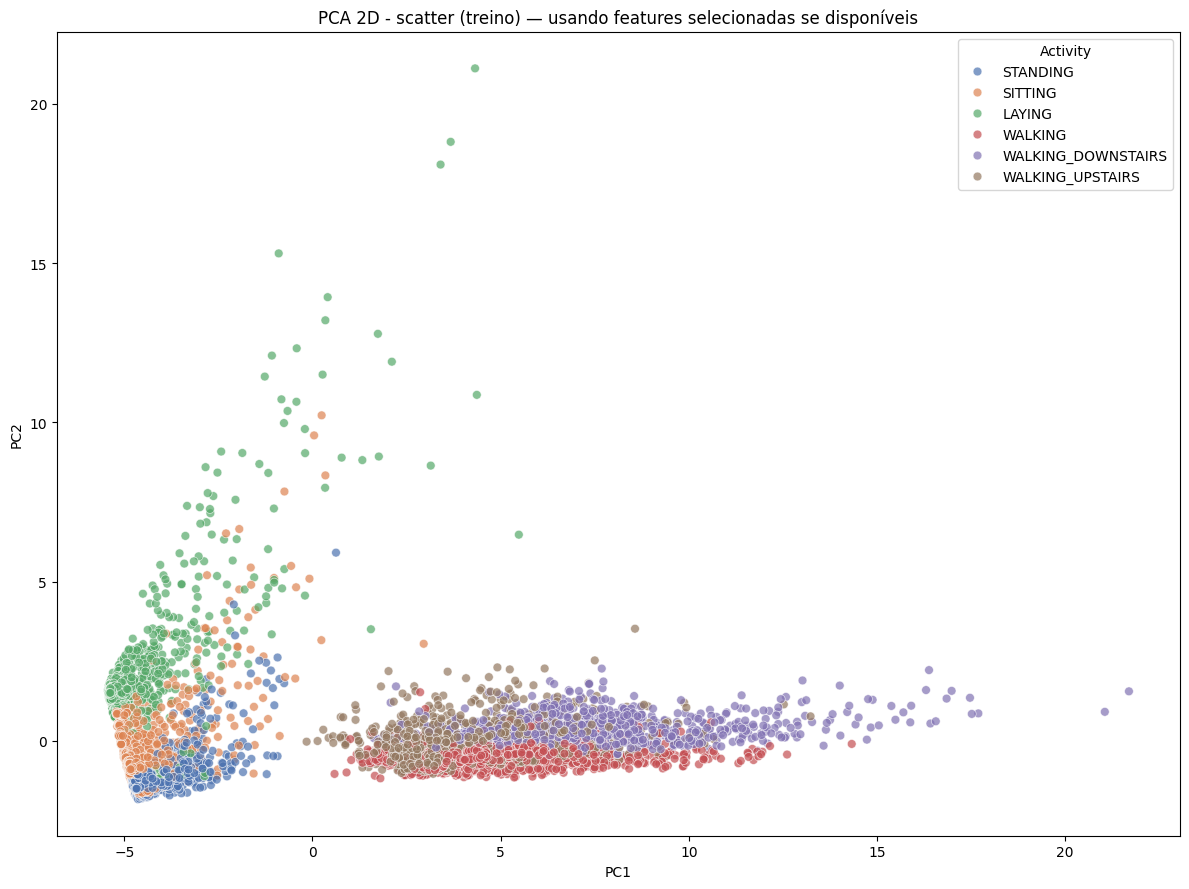

In [33]:
# Célula 9 - PCA 2D (scatter) - usa X_train_scaled e y_train
# Se rfecv / selected_features existirem, usa as features selecionadas; caso contrário, usa todas as features.

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

# garante X_train_scaled e y_train
try:
    X_train_scaled
    y_train
    X_train
except NameError:
    train_df = pd.read_csv("../data/processed/train_processed.csv")
    X_train = train_df.drop(columns=["subject", "activity_id", "activity"])
    y_train = train_df["activity"]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))

# escolhe features: prefere rfecv selecionadas, se disponíveis
try:
    if 'rfecv' in globals() and hasattr(rfecv, "support_"):
        mask = rfecv.support_
        X_for_pca = X_train_scaled[:, mask]
    elif 'selected_features' in globals():
        cols = list(X_train.columns)
        mask = [c in selected_features for c in cols]
        X_for_pca = X_train_scaled[:, mask]
    else:
        X_for_pca = X_train_scaled
except Exception:
    X_for_pca = X_train_scaled

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_for_pca)

# encode das labels
le = LabelEncoder()
y_codes = le.fit_transform(y_train)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Activity"] = y_train.values

print(f"Variância explicada pelos 2 componentes: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

plt.figure(figsize=(12,9))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Activity", palette="deep", alpha=0.7, s=40)
plt.title("PCA 2D - scatter (treino) — usando features selecionadas se disponíveis")
plt.tight_layout()

Path("../results").mkdir(parents=True, exist_ok=True)
plt.savefig("../results/pca_2d_scatter.png", bbox_inches='tight')
plt.show()

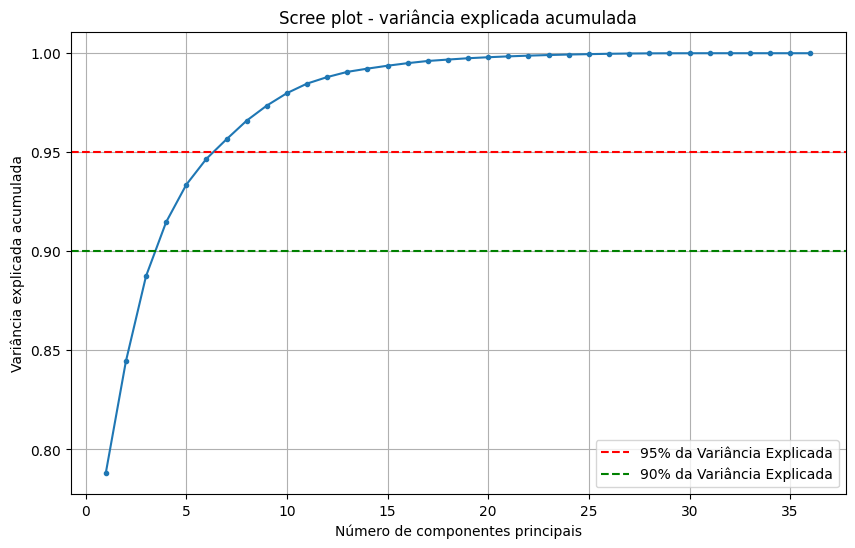

Número de componentes para explicar pelo menos 95% da variância: 7


In [34]:
# Célula 10 - Scree plot (variância explicada acumulada)
from pathlib import Path

# garante X_for_pca (usado na célula 9); se não existir, usa X_train_scaled
try:
    X_for_pca
except NameError:
    X_for_pca = X_train_scaled

max_comp = min(50, X_for_pca.shape[1])
pca_full = PCA(n_components=max_comp)
pca_full.fit(X_for_pca)

explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(10,6))
components = np.arange(1, len(cum_explained)+1)
plt.plot(components, cum_explained, marker=".")
plt.axhline(y=0.95, linestyle='--', color='red', label='95% da Variância Explicada')
plt.axhline(y=0.90, linestyle='--', color='green', label='90% da Variância Explicada')
plt.xlabel("Número de componentes principais")
plt.ylabel("Variância explicada acumulada")
plt.title("Scree plot - variância explicada acumulada")
plt.grid(True)
plt.legend()

Path("../results").mkdir(parents=True, exist_ok=True)
plt.savefig("../results/scree_plot.png", bbox_inches='tight')
plt.show()

# número de componentes para 95% (se estiver no range)
if np.any(cum_explained >= 0.95):
    n_components_95 = np.argmax(cum_explained >= 0.95) + 1
    print(f"Número de componentes para explicar pelo menos 95% da variância: {n_components_95}")
else:
    print("95% da variância não foi atingida com os primeiros", max_comp, "componentes (tente aumentar n_components).")

Atributos zerados pelo Lasso: 25 / 66


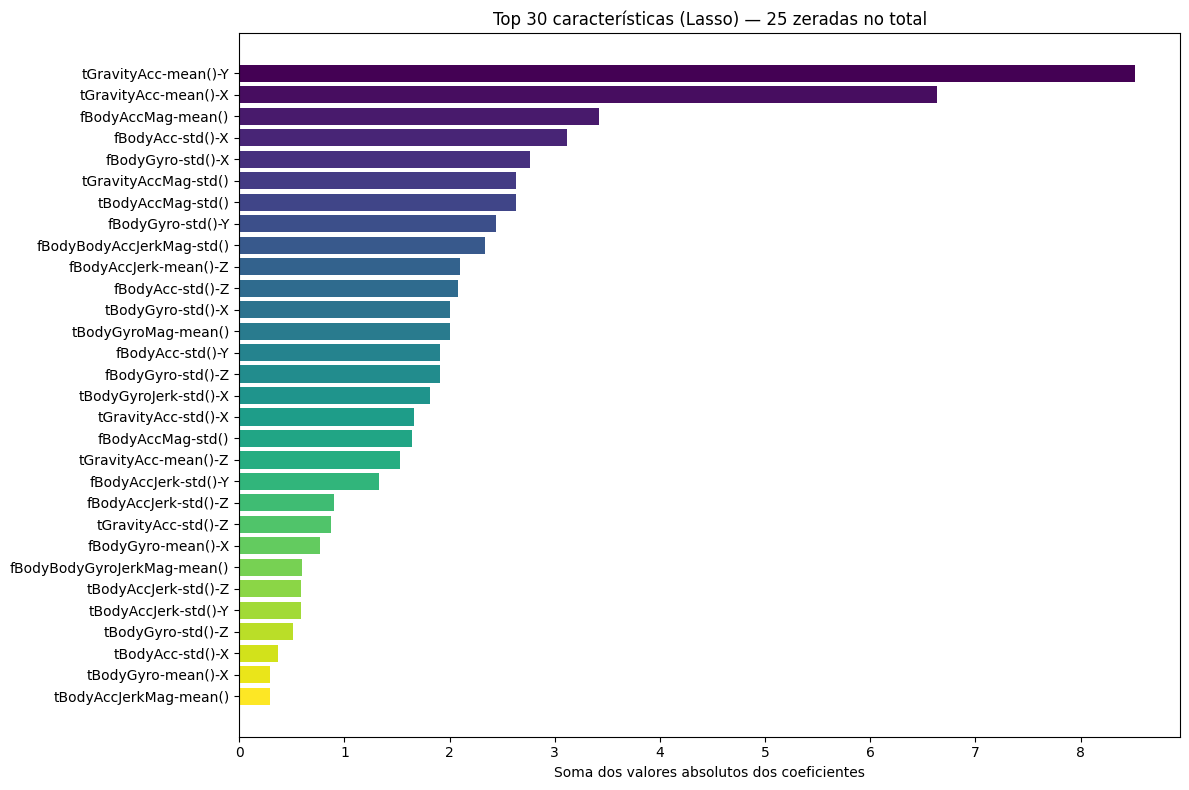

Salvo: ../results/lasso_top30_coeffs.png e ../results/lasso_feature_importance.csv


In [37]:
# Célula 11 (corrigida) - Visualizar coeficientes do Lasso (Top 30) sem gerar FutureWarning
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# garante que imp_series exista (fallback: treina um L1 rápido se necessário)
try:
    imp_series
except NameError:
    try:
        coefs  # se coefs já existir
    except NameError:
        # fallback: treina L1 (saga é bom para datasets maiores)
        l1_model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, C=0.1)
        l1_model.fit(X_train_scaled, y_train)
        coefs = l1_model.coef_
    importance = np.sum(np.abs(coefs), axis=0)
    feat_names = list(X_train.columns)
    imp_series = pd.Series(importance, index=feat_names).sort_values(ascending=False)

n_zerados = int((imp_series == 0).sum())
print(f"Atributos zerados pelo Lasso: {n_zerados} / {len(imp_series)}")

# Top-K para plotar
top_k = 30
top = imp_series.iloc[:top_k]

# Cores pelo colormap 'viridis'
colors = plt.cm.viridis(np.linspace(0, 1, top_k))

plt.figure(figsize=(12, 8))
y_pos = np.arange(len(top))
plt.barh(y_pos, top.values, color=colors)
plt.yticks(y_pos, top.index)
plt.gca().invert_yaxis()  # mostra o topo com a feature mais importante
plt.xlabel("Soma dos valores absolutos dos coeficientes")
plt.title(f"Top {top_k} características (Lasso) — {n_zerados} zeradas no total")
plt.tight_layout()

# salvar figura e CSV
Path("../results").mkdir(parents=True, exist_ok=True)
plt.savefig("../results/lasso_top30_coeffs.png", bbox_inches='tight')
plt.show()

imp_series.to_csv("../results/lasso_feature_importance.csv", header=["importance"])
print("Salvo: ../results/lasso_top30_coeffs.png e ../results/lasso_feature_importance.csv")

Atributos RFE: 36
Atributos Lasso: 41
Atributos em comum: 27
CSV salvo em ../results/compare_rfe_lasso.csv


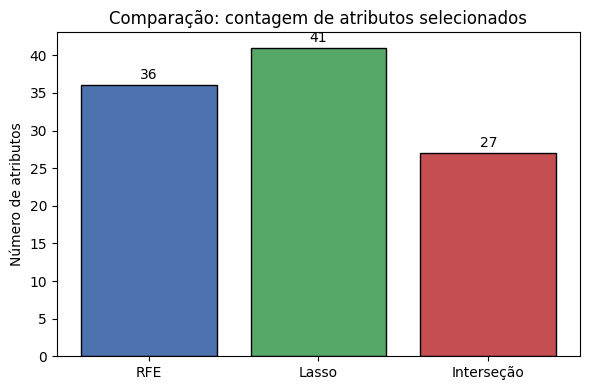

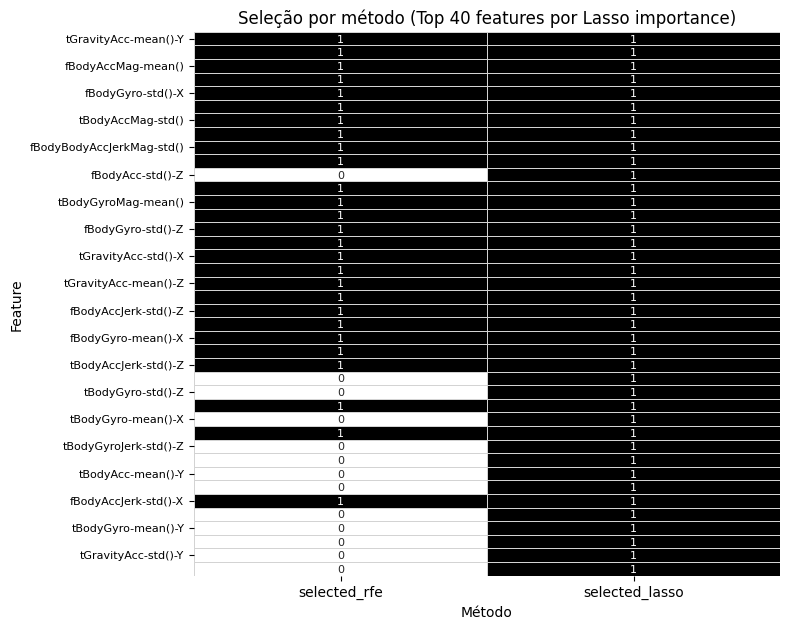


Exemplos (até 10) — atributos em comum:
['fBodyAcc-std()-X', 'fBodyAcc-std()-Y', 'fBodyAccJerk-mean()-Z', 'fBodyAccJerk-std()-X', 'fBodyAccJerk-std()-Y', 'fBodyAccJerk-std()-Z', 'fBodyAccMag-mean()', 'fBodyAccMag-std()', 'fBodyBodyAccJerkMag-std()', 'fBodyBodyGyroJerkMag-mean()']

Exemplos (até 10) — exclusivos RFE:
['fBodyAcc-mean()-Y', 'fBodyAcc-mean()-Z', 'fBodyBodyGyroJerkMag-std()', 'fBodyBodyGyroMag-std()', 'fBodyGyro-mean()-Z', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyGyro-std()-Y', 'tBodyGyroJerk-std()-Y']

Exemplos (até 10) — exclusivos Lasso:
['fBodyAcc-std()-Z', 'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAccJerk-mean()-X', 'tBodyAccJerk-mean()-Z', 'tBodyAccJerk-std()-Y', 'tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-std()-Z']

Preview salvo em ../results/compare_rfe_lasso_preview200.csv


In [40]:
# Célula 12 (corrigida) - Comparação RFE x Lasso: contagens + heatmap legível p/ Top-K
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ========== 1) Garantir variáveis essenciais ==========
# selected_features  <- lista vinda do RFECV/RFE
# selected_features_lasso <- lista vinda do Lasso
# imp_series <- pd.Series com importâncias do Lasso (decrescente, index = feature names)

# tentar extrair selected_features do rfecv se não estiver definida
try:
    selected_features
except NameError:
    try:
        selected_features = list(X_train.columns[rfecv.support_])
    except Exception:
        selected_features = []

# tentar reconstruir selected_features_lasso se não existir
try:
    selected_features_lasso
except NameError:
    try:
        selected_mask_lasso = (imp_series > 0)
        selected_features_lasso = list(imp_series[selected_mask_lasso].index)
    except Exception:
        selected_features_lasso = []

# se imp_series não existir, tenta construir a partir de lasso_model
try:
    imp_series
except NameError:
    try:
        coefs = lasso_model.coef_
        importance = np.sum(np.abs(coefs), axis=0)
        feat_names = list(X_train.columns)
        imp_series = pd.Series(importance, index=feat_names).sort_values(ascending=False)
    except Exception:
        # fallback: zero importances
        imp_series = pd.Series(0, index=list(X_train.columns))

# ========== 2) DataFrame comparativo (completo) ==========
all_feats = list(X_train.columns)
comp_df = pd.DataFrame({
    "feature": all_feats,
    "selected_rfe": [1 if f in selected_features else 0 for f in all_feats],
    "selected_lasso": [1 if f in selected_features_lasso else 0 for f in all_feats],
    "lasso_importance": [float(imp_series.get(f, 0.0)) for f in all_feats]
})

# contagens e interseção
set_rfe = set(selected_features)
set_lasso = set(selected_features_lasso)
n_rfe = len(set_rfe)
n_lasso = len(set_lasso)
n_common = len(set_rfe.intersection(set_lasso))

print(f"Atributos RFE: {n_rfe}")
print(f"Atributos Lasso: {n_lasso}")
print(f"Atributos em comum: {n_common}")

# salvar CSV completo
Path("../results").mkdir(parents=True, exist_ok=True)
comp_df.to_csv("../results/compare_rfe_lasso.csv", index=False)
print("CSV salvo em ../results/compare_rfe_lasso.csv")

# ========== 3) Gráfico de contagem - RFE / Lasso / Interseção ==========
plt.figure(figsize=(6,4))
vals = [n_rfe, n_lasso, n_common]
labels = ["RFE", "Lasso", "Interseção"]
colors = ["#4C72B0", "#55A868", "#C44E52"]
bars = plt.bar(labels, vals, color=colors, edgecolor='black')
for bar, v in zip(bars, vals):
    plt.text(bar.get_x() + bar.get_width()/2, v + max(vals)*0.01, str(v), ha='center', va='bottom', fontsize=10)
plt.title("Comparação: contagem de atributos selecionados")
plt.ylabel("Número de atributos")
plt.tight_layout()
plt.savefig("../results/compare_counts.png", bbox_inches='tight')
plt.show()

# ========== 4) Heatmap legível para TOP_K features por Lasso importance ==========
TOP_K = 40  # ajuste se desejar (20, 30, 50...)
# selecionar top features por importância Lasso
if imp_series.sum() == 0:
    # fallback: usar features com maior soma entre seleções (freq)
    rank_df = comp_df.copy()
    rank_df["sum_sel"] = rank_df["selected_rfe"] + rank_df["selected_lasso"]
    top_feats = rank_df.sort_values(["sum_sel","lasso_importance"], ascending=[False, False])["feature"].iloc[:TOP_K].tolist()
else:
    top_feats = imp_series.index[:TOP_K].tolist()

# construir matriz (Top_K x métodos)
heat_df = comp_df.set_index("feature").loc[top_feats, ["selected_rfe", "selected_lasso"]]

# plot heatmap (com anotações 0/1)
plt.figure(figsize=(8, max(4, TOP_K * 0.16)))
sns.heatmap(heat_df, cmap="Greys", cbar=False, linewidths=0.4, linecolor="lightgray",
            annot=True, fmt="d", annot_kws={"size":8})
plt.title(f"Seleção por método (Top {len(top_feats)} features por Lasso importance)")
plt.ylabel("Feature")
plt.xlabel("Método")
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig("../results/compare_top_features_heatmap.png", bbox_inches='tight')
plt.show()

# ========== 5) Pequena amostra textual para relatório ==========
common_list = sorted(list(set_rfe.intersection(set_lasso)))
only_rfe = sorted(list(set_rfe.difference(set_lasso)))
only_lasso = sorted(list(set_lasso.difference(set_rfe)))

print("\nExemplos (até 10) — atributos em comum:")
print(common_list[:10])

print("\nExemplos (até 10) — exclusivos RFE:")
print(only_rfe[:10])

print("\nExemplos (até 10) — exclusivos Lasso:")
print(only_lasso[:10])

# salva preview CSV (primeiras 200 linhas do comp_df)
comp_df.head(200).to_csv("../results/compare_rfe_lasso_preview200.csv", index=False)
print("\nPreview salvo em ../results/compare_rfe_lasso_preview200.csv")


Variância explicada por PC1+PC2: 70.86%
Silhouette score (PCA 2D): 0.0433  (valores mais altos = melhor separação)
Distância média entre centróides das classes (PC1-2): 8.342


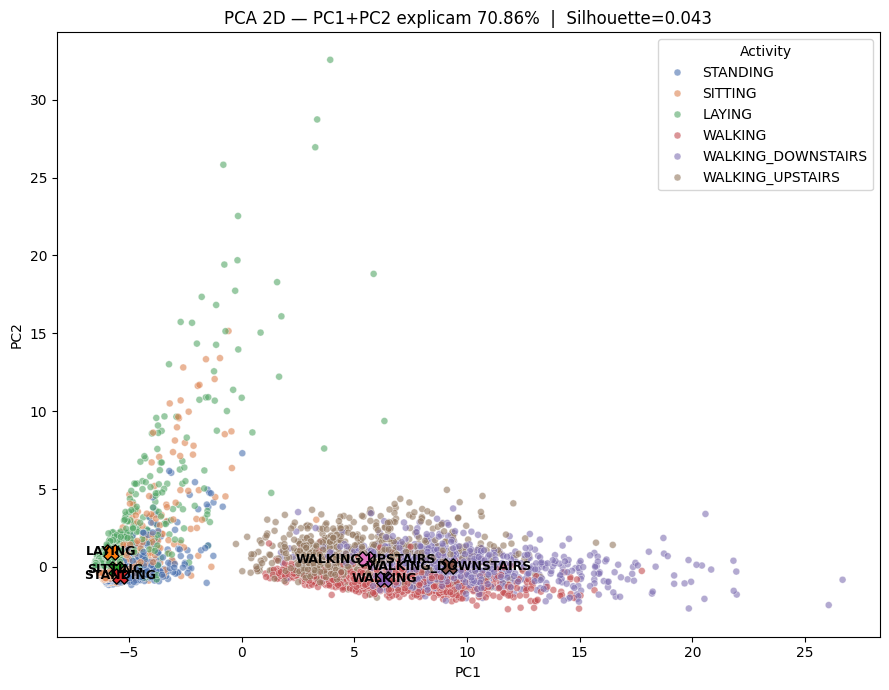

In [41]:
# Célula 13 - PCA: separação visual + silhouette + distâncias entre centróides
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from pathlib import Path
import pandas as pd

# garantir X_train_scaled e y_train
try:
    X_train_scaled
    y_train
    X_train
except NameError:
    train_df = pd.read_csv("../data/processed/train_processed.csv")
    X_train = train_df.drop(columns=["subject","activity_id","activity"])
    y_train = train_df["activity"]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))

# usar features selecionadas se existirem (prefira rfecv selecionadas)
try:
    if 'rfecv' in globals() and hasattr(rfecv, "support_"):
        mask = rfecv.support_
        X_for_pca = X_train_scaled[:, mask]
        cols_for_pca = list(X_train.columns)[mask]
    elif 'selected_features' in globals() and len(selected_features)>0:
        cols = list(X_train.columns)
        mask = [c in selected_features for c in cols]
        X_for_pca = X_train_scaled[:, mask]
        cols_for_pca = [c for c,m in zip(cols,mask) if m]
    else:
        X_for_pca = X_train_scaled
        cols_for_pca = list(X_train.columns)
except Exception:
    X_for_pca = X_train_scaled
    cols_for_pca = list(X_train.columns)

# PCA 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_for_pca)
explained_2 = pca.explained_variance_ratio_.sum()
print(f"Variância explicada por PC1+PC2: {explained_2*100:.2f}%")

# Silhouette score no espaço PCA (mais representativo que no espaço original para visualização)
try:
    sil = silhouette_score(X_pca, y_train)
    print(f"Silhouette score (PCA 2D): {sil:.4f}  (valores mais altos = melhor separação)")
except Exception as e:
    print("Silhouette não pôde ser calculado:", e)

# centroides por classe e distância média inter-centróides / intra-classe
labels = np.array(y_train)
classes = np.unique(labels)
centroids = {c: X_pca[labels==c].mean(axis=0) for c in classes}
# distância média entre centróides (pairwise)
dists = []
for i,ci in centroids.items():
    for j,cj in centroids.items():
        if i < j:
            dists.append(np.linalg.norm(ci-cj))
mean_centroid_dist = np.mean(dists)
print(f"Distância média entre centróides das classes (PC1-2): {mean_centroid_dist:.3f}")

# plot PCA com centróides
plt.figure(figsize=(9,7))
dfp = pd.DataFrame(X_pca, columns=["PC1","PC2"])
dfp["Activity"] = labels
sns.scatterplot(data=dfp, x="PC1", y="PC2", hue="Activity", s=25, alpha=0.6, palette="deep", legend='full')
# plotar centróides
for c,ctr in centroids.items():
    plt.scatter(ctr[0], ctr[1], marker='X', s=120, edgecolor='k')
    plt.text(ctr[0], ctr[1], str(c), fontsize=9, fontweight='bold', horizontalalignment='center', verticalalignment='center')
plt.title(f"PCA 2D — PC1+PC2 explicam {explained_2*100:.2f}%  |  Silhouette={sil:.3f}")
plt.tight_layout()
Path("../results").mkdir(parents=True, exist_ok=True)
plt.savefig("../results/pca_2d_with_centroids.png", bbox_inches='tight')
plt.show()


In [42]:
# Célula 14 - Loadings: principais features que compõem PC1 e PC2 (interpretação)
import pandas as pd
import numpy as np
from pathlib import Path

# usa o mesmo PCA da célula anterior (se não existir, recalcula usando X_for_pca)
try:
    pca
except NameError:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_for_pca)

# componentes: pca.components_ -> shape (n_components, n_features)
components = pca.components_  # [PC1 vector, PC2 vector]
feat_names = cols_for_pca

# criar DataFrame de loadings
loadings = pd.DataFrame(components.T, index=feat_names, columns=["PC1","PC2"])
loadings["abs_PC1"] = loadings["PC1"].abs()
loadings["abs_PC2"] = loadings["PC2"].abs()

# Top contributors (por magnitude) para cada PC
top_pc1 = loadings.sort_values("abs_PC1", ascending=False).head(15)
top_pc2 = loadings.sort_values("abs_PC2", ascending=False).head(15)

print("Top 15 features por contribuição absoluta em PC1:")
display(top_pc1[["PC1","abs_PC1"]])

print("\nTop 15 features por contribuição absoluta em PC2:")
display(top_pc2[["PC2","abs_PC2"]])

# Salvar para relatório
Path("../results").mkdir(parents=True, exist_ok=True)
loadings.to_csv("../results/pca_loadings_pc1_pc2.csv")
print("Loadings salvos em ../results/pca_loadings_pc1_pc2.csv")


Top 15 features por contribuição absoluta em PC1:


,PC1,abs_PC1
tBodyAccJerkMag-mean(),0.148651,0.148651
fBodyBodyAccJerkMag-mean(),0.147693,0.147693
tBodyAccJerkMag-std(),0.147396,0.147396
tGravityAccMag-mean(),0.147180,0.147180
tBodyAccMag-mean(),0.147180,0.147180
fBodyAcc-mean()-Y,0.147060,0.147060
fBodyAccMag-mean(),0.146979,0.146979
tBodyAccJerk-std()-X,0.146610,0.146610
fBodyAccJerk-mean()-X,0.146371,0.146371
tBodyGyroMag-mean(),0.146315,0.146315



Top 15 features por contribuição absoluta em PC2:


,PC2,abs_PC2
tGravityAcc-std()-X,0.504259,0.504259
tGravityAcc-std()-Z,0.460651,0.460651
tGravityAcc-std()-Y,0.436562,0.436562
tBodyAcc-mean()-X,-0.288867,0.288867
tGravityAcc-mean()-X,-0.174718,0.174718
tBodyAcc-mean()-Z,0.167937,0.167937
tGravityAcc-mean()-Z,0.141714,0.141714
tGravityAcc-mean()-Y,0.136054,0.136054
tBodyGyro-mean()-Y,-0.122548,0.122548
fBodyAccMag-std(),0.119953,0.119953


Loadings salvos em ../results/pca_loadings_pc1_pc2.csv


RFE selecionou 36 features; Lasso selecionou 41 features
Interseção: 27 features
Jaccard Index (RFE, Lasso): 0.5400

Até 20 features em comum (ex): ['tGravityAcc-mean()-X', 'fBodyGyro-mean()-X', 'fBodyBodyGyroJerkMag-mean()', 'fBodyAccJerk-std()-Z', 'tBodyGyro-std()-X', 'fBodyAccMag-mean()', 'tGravityAcc-std()-X', 'fBodyAcc-std()-X', 'tBodyGyroJerk-std()-X', 'fBodyAcc-std()-Y', 'tGravityAcc-mean()-Z', 'tBodyAccMag-std()', 'fBodyBodyAccJerkMag-std()', 'fBodyGyro-std()-Y', 'tBodyAccJerkMag-mean()', 'fBodyAccMag-std()', 'tBodyGyroMag-mean()', 'fBodyAccJerk-mean()-Z', 'tGravityAccMag-std()', 'tGravityAcc-mean()-Y']

Até 20 exclusivas RFE: ['fBodyBodyGyroMag-std()', 'fBodyBodyGyroJerkMag-std()', 'tBodyGyro-std()-Y', 'tBodyAcc-std()-Y', 'fBodyAcc-mean()-Y', 'tBodyAcc-std()-Z', 'fBodyAcc-mean()-Z', 'tBodyGyroJerk-std()-Y', 'fBodyGyro-mean()-Z']

Até 20 exclusivas Lasso: ['tGravityAcc-std()-Y', 'fBodyAcc-std()-Z', 'tBodyAcc-mean()-Y', 'tBodyGyroJerk-mean()-Z', 'tBodyAcc-mean()-Z', 'tBodyGyro-m

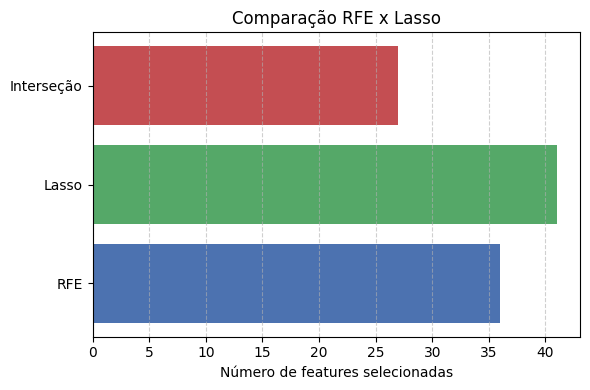

In [46]:
# Célula 15 - Comparação RFE x Lasso: Jaccard, listas e gráfico
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# garantir sets
try:
    set_rfe = set(selected_features)  # do RFECV
except Exception:
    set_rfe = set()

try:
    set_lasso = set(selected_features_lasso)  # do Lasso
except Exception:
    try:
        set_lasso = set(imp_series[imp_series > 0].index.tolist())
    except Exception:
        set_lasso = set()

# medidas de interseção e similaridade
intersection = set_rfe.intersection(set_lasso)
union = set_rfe.union(set_lasso)
jaccard = len(intersection) / len(union) if len(union) > 0 else 0.0

print(f"RFE selecionou {len(set_rfe)} features; Lasso selecionou {len(set_lasso)} features")
print(f"Interseção: {len(intersection)} features")
print(f"Jaccard Index (RFE, Lasso): {jaccard:.4f}")

# listar exemplos
print("\nAté 20 features em comum (ex):", list(intersection)[:20])
print("\nAté 20 exclusivas RFE:", list(set_rfe - set_lasso)[:20])
print("\nAté 20 exclusivas Lasso:", list(set_lasso - set_rfe)[:20])

# gráfico de contagem comparativa (usando Matplotlib direto para evitar warnings do Seaborn)
vals = [len(set_rfe), len(set_lasso), len(intersection)]
labels = ["RFE", "Lasso", "Interseção"]
colors = ["#4C72B0", "#55A868", "#C44E52"]

plt.figure(figsize=(6,4))
plt.barh(labels, vals, color=colors)
plt.title("Comparação RFE x Lasso")
plt.xlabel("Número de features selecionadas")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()

# salvar
Path("../results").mkdir(parents=True, exist_ok=True)
plt.savefig("../results/rfe_lasso_jaccard.png", bbox_inches="tight")
plt.show()


In [47]:
# Célula 16 - ANOVA (f-score) para conjuntos de features (RFE e Lasso)
from sklearn.feature_selection import f_classif
import pandas as pd

# garantir X_train (DataFrame) e y_train
try:
    X_train
except NameError:
    train_df = pd.read_csv("../data/processed/train_processed.csv")
    X_train = train_df.drop(columns=["subject","activity_id","activity"])
    y_train = train_df["activity"]

# função para média f-score de um conjunto
def mean_fscore(features_list):
    if len(features_list)==0:
        return None
    X_sub = X_train[features_list].astype(np.float32).values
    fvals, pvals = f_classif(X_sub, y_train)
    return np.mean(fvals), pd.Series(fvals, index=features_list).sort_values(ascending=False).head(10)

rfe_stats = mean_fscore(list(set_rfe))
lasso_stats = mean_fscore(list(set_lasso))

print("Média F-score (top10) — RFE:")
if rfe_stats:
    print("Média F:", rfe_stats[0])
    display(rfe_stats[1])

print("\nMédia F-score (top10) — Lasso:")
if lasso_stats:
    print("Média F:", lasso_stats[0])
    display(lasso_stats[1])


Média F-score (top10) — RFE:
Média F: 8212.967619146433


tGravityAcc-mean()-X      29362.587391
tBodyAcc-std()-X          18213.441491
fBodyAcc-std()-X          16689.447808
tBodyAccJerkMag-mean()    12944.174179
fBodyAcc-mean()-Y         12697.035563
fBodyAccMag-mean()        12641.886267
tBodyAcc-std()-Y          12039.717261
fBodyAccJerk-std()-X      11554.738549
tGravityAccMag-std()      11058.938541
tBodyAccMag-std()         11058.938541
dtype: float64


Média F-score (top10) — Lasso:
Média F: 6484.667976498991


tGravityAcc-mean()-X         29362.587391
tBodyAcc-std()-X             18213.441491
fBodyAcc-std()-X             16689.447808
tBodyAccJerkMag-mean()       12944.174179
fBodyAccMag-mean()           12641.886267
fBodyAccJerk-std()-X         11554.738549
tBodyAccJerk-std()-Y         11246.794228
tGravityAccMag-std()         11058.938541
tBodyAccMag-std()            11058.938541
fBodyBodyAccJerkMag-std()    10910.690374
dtype: float64